CODE FOR TRAINING THE MODEL

LIBRARY IMPORTS

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

LOADING DATA

In [1]:
data_dirs = {
    "URTI": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\URTI",
    "Healthy": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Healthy",
    "COPD": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\COPD",
    "Bronchiectasis": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Bronchiectasis",
    "Pneumonia": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Pneumonia",
    "Bronchiolitis": r"C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Bronchiolitis"
}

for disease, path in data_dirs.items():
    print(f"Loaded {disease} data directory: {path}")

# Load data and labels
X = []  # Spectrograms
y = []  # Labels

for label, folder_path in data_dirs.items():
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".npy"):
            file_path = os.path.join(folder_path, file_name)
            data = np.load(file_path)  # Shape: (128, 128, 1)
            X.append(data)
            y.append(label)

# Convert to numpy arrays
X = np.array(X)  # Shape: (n_samples, 128, 128, 1)
y = np.array(y)  # Shape: (n_samples,)

Loaded URTI data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\URTI
Loaded Healthy data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Healthy
Loaded COPD data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\COPD
Loaded Bronchiectasis data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Bronchiectasis
Loaded Pneumonia data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Pneumonia
Loaded Bronchiolitis data directory: C:\Users\Jiary\Documents\GitHub\ML\Spectograms\Bronchiolitis


NameError: name 'os' is not defined

ENCODING LABELS

In [5]:
 # Convert labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(y)  # Fit on all labels in the dataset
# Step 2: Encode the labels
y_encoded = label_encoder.transform(y)
# Example mapping
print(f'Total spectrograms: {len(X)}')
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Total spectrograms: 8825
Label mapping: {'Bronchiectasis': 0, 'Bronchiolitis': 1, 'COPD': 2, 'Healthy': 3, 'Pneumonia': 4, 'URTI': 5}


SPLIT TRAIN-EVALUATE-TEST DATA

In [6]:
# Stratified split into training (70%) and temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# Print sizes
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples\n\n")
# Function to count samples per class
def count_samples(y_encoded, label_encoder):
    unique, counts = np.unique(y_encoded, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"Class: {label_encoder.inverse_transform([cls])[0]}, Samples: {count}")

# Print distribution in training set
print("Training Set Distribution:")
count_samples(y_train, label_encoder)

# Print distribution in validation set
print("\nValidation Set Distribution:")
count_samples(y_val, label_encoder)

# Print distribution in testing set
print("\nTesting Set Distribution:")
count_samples(y_test, label_encoder)


Training set: 6177 samples
Validation set: 1324 samples
Testing set: 1324 samples


Training Set Distribution:
Class: Bronchiectasis, Samples: 349
Class: Bronchiolitis, Samples: 364
Class: COPD, Samples: 4022
Class: Healthy, Samples: 498
Class: Pneumonia, Samples: 490
Class: URTI, Samples: 454

Validation Set Distribution:
Class: Bronchiectasis, Samples: 75
Class: Bronchiolitis, Samples: 78
Class: COPD, Samples: 862
Class: Healthy, Samples: 107
Class: Pneumonia, Samples: 105
Class: URTI, Samples: 97

Testing Set Distribution:
Class: Bronchiectasis, Samples: 75
Class: Bronchiolitis, Samples: 78
Class: COPD, Samples: 862
Class: Healthy, Samples: 107
Class: Pneumonia, Samples: 105
Class: URTI, Samples: 97


CNN-MODEL

In [12]:
# Define the CNN model
model = Sequential([
    # Convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    
    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flatten the output
    Flatten(),
    
    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    
    # Output layer (6 classes for your dataset)
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_test dtype: {X_test.dtype}")
print(f"y_test dtype: {y_test.dtype}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,710 (12.64 MB)

 Trainable params: 3,312,710 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

X_train dtype: float32
y_train dtype: int32
X_test dtype: float32
y_test dtype: int32


TRAIN MODEL

In [13]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 166s 829ms/step - accuracy: 0.5643 - loss: 3.6541 - val_accuracy: 0.6511 - val_loss: 1.2356
Epoch 2/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 133s 684ms/step - accuracy: 0.6548 - loss: 1.0884 - val_accuracy: 0.6511 - val_loss: 0.9029
Epoch 3/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 168s 818ms/step - accuracy: 0.6484 - loss: 0.9528 - val_accuracy: 0.6775 - val_loss: 0.9628
Epoch 4/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 137s 705ms/step - accuracy: 0.7012 - loss: 0.8292 - val_accuracy: 0.6918 - val_loss: 0.7751
Epoch 5/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 148s 736ms/step - accuracy: 0.6982 - loss: 0.8067 - val_accuracy: 0.6903 - val_loss: 0.8701
Epoch 6/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.7188 - loss: 0.7767 - val_accuracy: 0.7644 - val_loss: 0.6446
Epoch 7/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7361 - loss: 0.7272 - val_accuracy: 0.7893 - val_loss: 0.5689
Epoch 8/20
194/194 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.7602 - loss: 0.

EVALUATE

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.8462 - loss: 0.4582
Test Accuracy: 0.829305112361908


PLOTS

                precision    recall  f1-score   support

Bronchiectasis       0.91      0.64      0.75        75
 Bronchiolitis       0.70      0.62      0.65        78
          COPD       0.93      0.95      0.94       862
       Healthy       0.50      0.72      0.59       107
     Pneumonia       0.66      0.68      0.67       105
          URTI       0.59      0.40      0.48        97

      accuracy                           0.83      1324
     macro avg       0.71      0.67      0.68      1324
  weighted avg       0.84      0.83      0.83      1324

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step


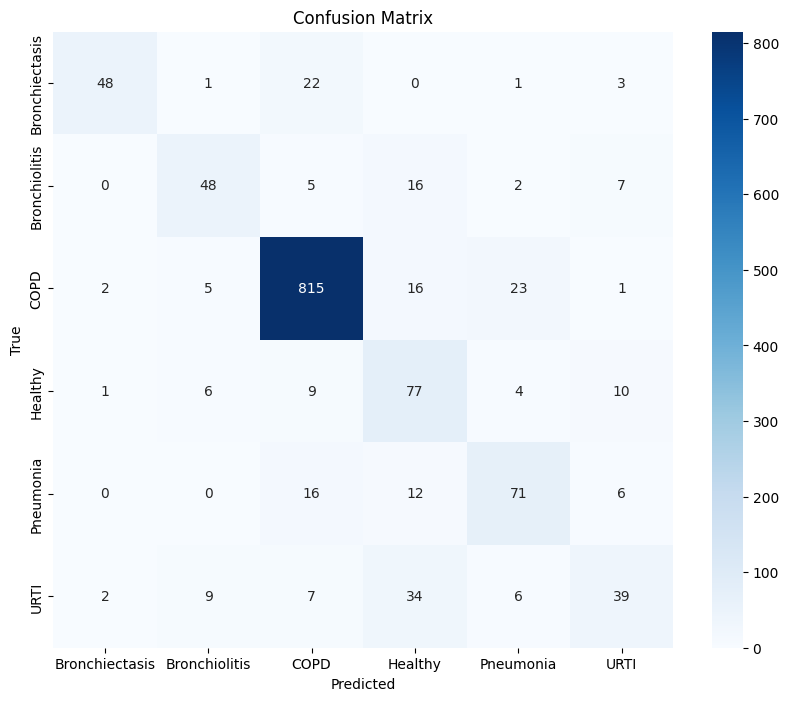

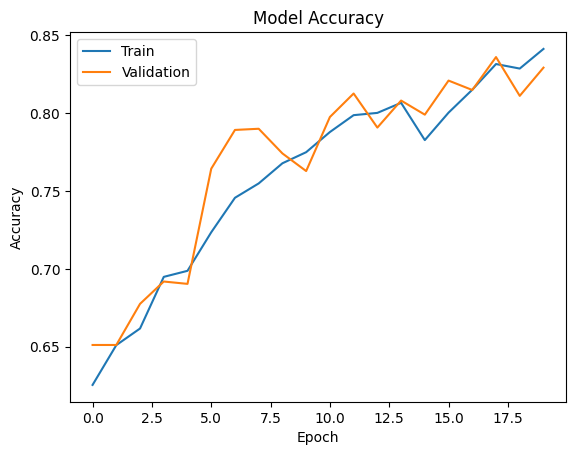

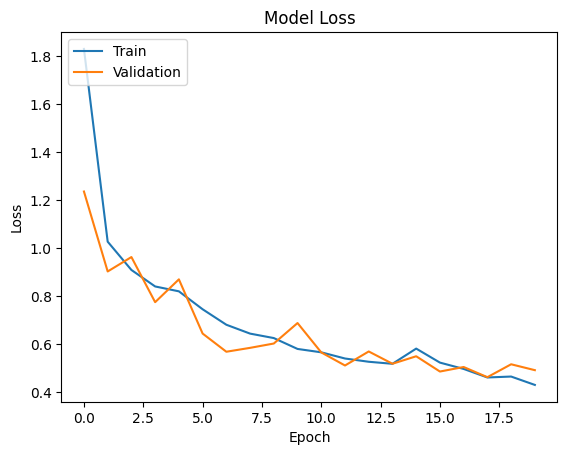

In [19]:
# Generate classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


SAVE MODEL

In [1]:
model.save('respiratory_cnn_model.h5')

NameError: name 'model' is not defined